# Evaluation and model interpretation

In [1]:
import pandas as pd
import numpy as np
import h5py

import torch
from dataclasses import make_dataclass

from importlib import reload
from src.datasets import UKBSnpLevelDatasetH5OneHot

from src.util import load_config
from src.graphs import GeneOntology
from src.vnn_trainer import GenoVNNLightning, FastVNNLightning, FastVNNLitReg


In [2]:
torch.cuda.is_available()

True

In [3]:
config_file = "src/config/gout_config.yaml"
config = load_config(config_file)
config["feature_dim"] = 3

In [4]:
config

{'onto': '../ontology.txt',
 'train': '../labels.csv',
 'label_col': 'gout',
 'mutations': '../genotype_data.h5',
 'epoch': 5,
 'lr': 0.0001,
 'wd': 0.001,
 'alpha': 0.3,
 'batchsize': 256,
 'modeldir': '/model_test/',
 'cuda': 0,
 'gene2id': '../ukb_snp_ids.csv',
 'genotype_hiddens': 4,
 'optimize': 1,
 'zscore_method': 'auc',
 'std': '/model_test/std.txt',
 'patience': 30,
 'delta': 0.001,
 'min_dropout_layer': 10,
 'dropout_fraction': 0.25,
 'lr_step_size': 4,
 'activation': 'leaky_relu',
 'task': 'classification',
 'onehot': True,
 'num_workers': 8,
 'run_name': 'gout',
 'num_covariates': 2,
 'feature_dim': 3}

In [5]:
args = make_dataclass(
    "DataclassFromConfig", [(k, type(v)) for k, v in config.items()]
)(**config)


In [6]:
gene_bim_file = "/cluster/project/beltrao/gankin/vnn/data/ukb_gene.bim"
gene_bim_df = pd.read_csv(gene_bim_file, sep="\t")

snp_id_map = {
    snp: ind
    for snp, ind in zip(
        gene_bim_df["snp"].unique(), range(0, len(gene_bim_df["snp"].unique()))
    )
}

graph = GeneOntology(
    snp_id_map,
    "/cluster/project/beltrao/gankin/vnn/snp_vnn/data/NEST_UKB_snp_onto.txt",
    child_node="snp",
)

/scratch/tmp.15978012.dgankin/ipykernel_1834548/1656017962.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_bim_df = pd.read_csv(gene_bim_file, sep="\t")


There are 1 roots: NEST
There are 18074 terms
There are 1 connected components


In [7]:
go_vnn_model = FastVNNLightning.load_from_checkpoint("/cluster/project/beltrao/gankin/vnn/snp_vnn/data/checkpoints/gout/epoch=6-step=10682.ckpt", args = args, graph=graph)

Constructing first NN layer
Constructing NN graph


In [8]:
from captum.attr import IntegratedGradients

/cluster/project/beltrao/gankin/software/miniconda3/envs/mamba_env/envs/vnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# construct random input
#data = hdf_data[idx, :]  # batch_size x num_snps
x = torch.randint(0, 3, (16, 429371))
print("shape", x.shape)
x = x.numpy()
data=x

#data = np.nan_to_num(data.T[snp_bed_ids].T)

# Convert data to torch tensor
data = torch.from_numpy(data).long()  # Ensure compatibility for one_hot

# One-hot encode the data (0, 1, or 2) across a new last dimension
data = torch.nn.functional.one_hot(data, num_classes=3).float()

shape torch.Size([16, 429371])


In [10]:
baseline = torch.zeros_like(torch.from_numpy(x)).long()
baseline_data = torch.nn.functional.one_hot(baseline, num_classes=3).float()
baseline_data.shape

torch.Size([16, 429371, 3])

In [11]:
age = torch.randint(1930, 1980, (16,1,3))
sex = torch.randint(0, 2, (16,1,3))
sex_baseline = torch.zeros_like(sex)
age_baseline = torch.zeros_like(age)
age_baseline = age_baseline + 1950

In [12]:
cov = torch.concat([age,sex], dim=1)
cov_baseline = torch.concat([age_baseline,sex_baseline], dim=1)

In [13]:
labels = torch.randint(0, 2, (16,1))
base_labels = torch.randint(0, 2, (16,1))

In [14]:
input = (torch.concat([data,cov], dim=1), labels)
#input_baseline = torch.concat

In [15]:
sample_data = ((data,cov), labels)
sample_baseline = ((baseline_data,cov_baseline), base_labels)

In [16]:
import lightning as L
# new lightning model 
class AnalyzeModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        #print(x.shape)
        data = x[:,:-2,:]
        cov = x[:,-2:,0]
        input = {"x": data, "covariates": cov}
        aux_out_map, _ = self.model(input)
        output = aux_out_map["final"].squeeze(1)
        output_logits = aux_out_map["final_logits"]
        return output_logits
    
    def training_step(self, batch, batch_idx):
        #data, cov = batch
        #input = {"x": data, "cov": cov}
        return self.model(batch)

In [17]:
model = AnalyzeModel(go_vnn_model)
model.eval()

AnalyzeModel(
  (model): FastVNNLightning(
    (model): FastVNN(
      (gene_layer): CompleteGeneModule(
        (linear): LinearColumns()
        (batchnorm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (graph_layer_0): GraphLayer(
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
        (linear1): SparseLinear(
          in_features=429371, out_features=72296, bias=False, sparsity=5.5064837726642904e-05, connectivity=tensor([[ 21892,  21893,  21894,  ...,  22289,  22290,  22291],
                  [     0,      0,      0,  ..., 429370, 429370, 429370]]), small_world=False
        )
        (batchnorm): BatchNorm1d(72296, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear2): SparseLinear(
          in_features=72296, out_features=18074, bias=False, sparsity=0.0013081356888085865, connectivity=tensor([[ 5473,  5

In [83]:
class RandomDataset(torch.utils.data.Dataset):
    def __init__(self, baseline=False):
        x = torch.randint(0, 3, (128, 429371))
        # One-hot encode the data (0, 1, or 2) across a new last dimension
        data = torch.nn.functional.one_hot(x, num_classes=3).float()
        self.data = data
        age = torch.randint(1930, 1980, (128,1))
        sex = torch.randint(0, 2, (128,1))
        self.covariates = torch.concat([age,sex], dim=1)

        self.labels = torch.randint(0, 2, (128,1))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        data = {"x": self.data[idx], "covariates": self.covariates[idx]}
        return data, self.labels[idx]

In [84]:
random_dataset = RandomDataset()
random_dataloader = torch.utils.data.DataLoader(random_dataset, batch_size=16)

In [18]:
ig = IntegratedGradients(model)

In [21]:
input[:1][0].size()

torch.Size([16, 429373, 3])

In [ ]:
inp = input[:1][0]

In [ ]:
input[1].squeeze()

tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [22]:
attributions, delta = ig.attribute(input[0].cuda(), target=0, n_steps=100, return_convergence_delta=True, internal_batch_size=16)

/home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [5,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [7,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [8,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [9,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` fail

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [23]:
delta

tensor([-0.0154, -0.0016, -0.0242,  0.0050, -0.0222,  0.0946,  0.0247,  0.0110,
         0.0435,  0.0397, -0.0211,  0.0194,  0.0084,  0.0479,  0.0424, -0.0122],
       device='cuda:0', dtype=torch.float64)

In [96]:
max_id = torch.argmax(attributions)
max_id/3

tensor(4402724., device='cuda:0')

In [27]:
att_mean = attributions.mean(dim=0)
abs_mean = attributions.abs().mean(dim=0)

In [29]:
att_sum[-2]

tensor([0.6403, 0.0000, 0.0000], device='cuda:0', dtype=torch.float64)

In [69]:
attributions[0]

tensor([[ 6.2035e-07,  0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -2.9012e-06,  0.0000e+00],
        [-0.0000e+00, -1.5367e-05,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  3.0918e-06],
        [-1.9167e-01,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0',
       dtype=torch.float64)

In [30]:
att_mean.max()

tensor(3.0643, device='cuda:0', dtype=torch.float64)

In [31]:
torch.argmax(att_mean)

tensor(326981, device='cuda:0')

In [45]:
att_sum[int(torch.argmax(att_sum)/3)]

tensor([-0.1890, -0.1633,  2.0275], device='cuda:0', dtype=torch.float64)

In [32]:
topk = torch.topk(att_mean.flatten(), 10)
tk_ind = torch.floor(topk.indices/3)

In [33]:
topk

torch.return_types.topk(
values=tensor([3.0643, 1.8855, 1.5333, 1.3567, 1.2945, 1.2787, 1.1127, 1.1111, 1.1059,
        1.0672], device='cuda:0', dtype=torch.float64),
indices=tensor([326981, 594289, 326935, 323784, 133330, 777478, 630071,  88186, 516413,
         61120], device='cuda:0'))

In [34]:
topk

torch.return_types.topk(
values=tensor([3.0643, 1.8855, 1.5333, 1.3567, 1.2945, 1.2787, 1.1127, 1.1111, 1.1059,
        1.0672], device='cuda:0', dtype=torch.float64),
indices=tensor([326981, 594289, 326935, 323784, 133330, 777478, 630071,  88186, 516413,
         61120], device='cuda:0'))

In [101]:
att_sum[tk_ind.long()]

tensor([[-1.8887e-01, -1.6335e-01,  2.0275e+00],
        [ 2.1419e-01,  1.7526e+00, -2.1383e-01],
        [-1.3948e-05, -1.7587e-05,  1.2703e+00],
        [-1.3218e-02,  1.2459e+00,  1.5506e-01],
        [-2.6211e-02,  1.1567e+00, -3.5901e-02],
        [ 1.2567e-02, -1.6466e-03,  1.1114e+00],
        [-3.0502e-03,  4.9314e-02,  1.0843e+00],
        [ 3.3522e-03,  1.0635e+00,  4.3683e-03],
        [-7.0623e-03,  1.0413e+00,  2.1541e-01],
        [-4.7536e-02, -1.0992e-02,  1.0192e+00]], device='cuda:0',
       dtype=torch.float64)

In [74]:
attributions[:,-2,0]

tensor([-0.1917, -0.1636, -0.1808, -0.1637, -0.9451, -1.1364, -0.1952, -0.1570,
        -0.1538, -0.1411, -1.3445, -0.1880, -1.3152, -0.1505, -0.1808, -1.4786],
       device='cuda:0', dtype=torch.float64)

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt


In [37]:
sns.set_context("talk")

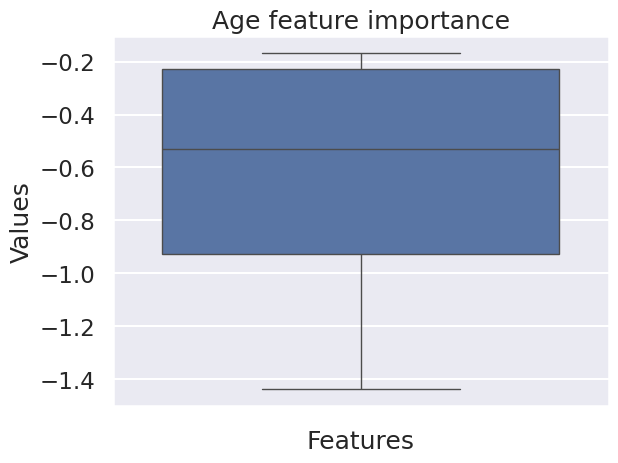

In [40]:
# Assuming 'last_part' is the extracted data from your tensor
# Converting the data into a Pandas DataFrame for use with Seaborn

# Plotting the boxplot with Seaborn
#plt.figure(figsize=(10, 6))
sns.boxplot(attributions[:,-2,0].cpu().numpy())
plt.title("Age feature importance")
plt.ylabel("Values")
plt.xlabel("Features")
plt.show()

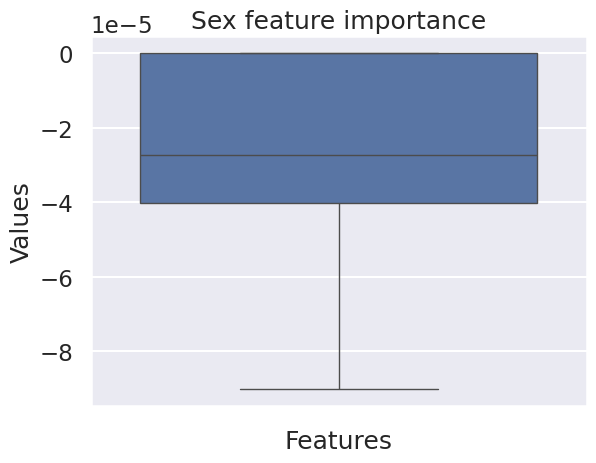

In [104]:
# Assuming 'last_part' is the extracted data from your tensor
# Converting the data into a Pandas DataFrame for use with Seaborn

# Plotting the boxplot with Seaborn
#plt.figure(figsize=(10, 6))
sns.boxplot(attributions[:,-1,0].cpu().numpy())
plt.title("Sex feature importance")
plt.ylabel("Values")
plt.xlabel("Features")
plt.show()

In [73]:
attributions[:,tk_ind.long()]

tensor([[[-0.0000e+00, -3.3899e-01,  0.0000e+00],
         [ 0.0000e+00,  3.8637e+00, -0.0000e+00],
         [-1.1195e-04, -0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  6.4410e-01],
         [-0.0000e+00,  3.1833e+00, -0.0000e+00],
         [ 0.0000e+00, -0.0000e+00,  2.2185e+00],
         [-0.0000e+00,  0.0000e+00,  4.2038e+00],
         [ 0.0000e+00,  2.2005e+00,  0.0000e+00],
         [-0.0000e+00,  2.0456e+00,  0.0000e+00],
         [-0.0000e+00, -0.0000e+00,  2.4657e+00]],

        [[-0.0000e+00, -0.0000e+00,  8.1467e+00],
         [ 0.0000e+00,  3.9782e+00, -0.0000e+00],
         [-0.0000e+00, -0.0000e+00,  1.9904e+00],
         [-0.0000e+00,  0.0000e+00,  6.6054e-01],
         [-0.0000e+00,  0.0000e+00, -8.2354e-03],
         [ 0.0000e+00, -0.0000e+00,  2.2196e+00],
         [-7.0968e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  5.2161e-04],
         [-2.9434e-03,  0.0000e+00,  0.0000e+00],
         [-2.2911e-01, -0.0000e+00,  0.0000e+00]

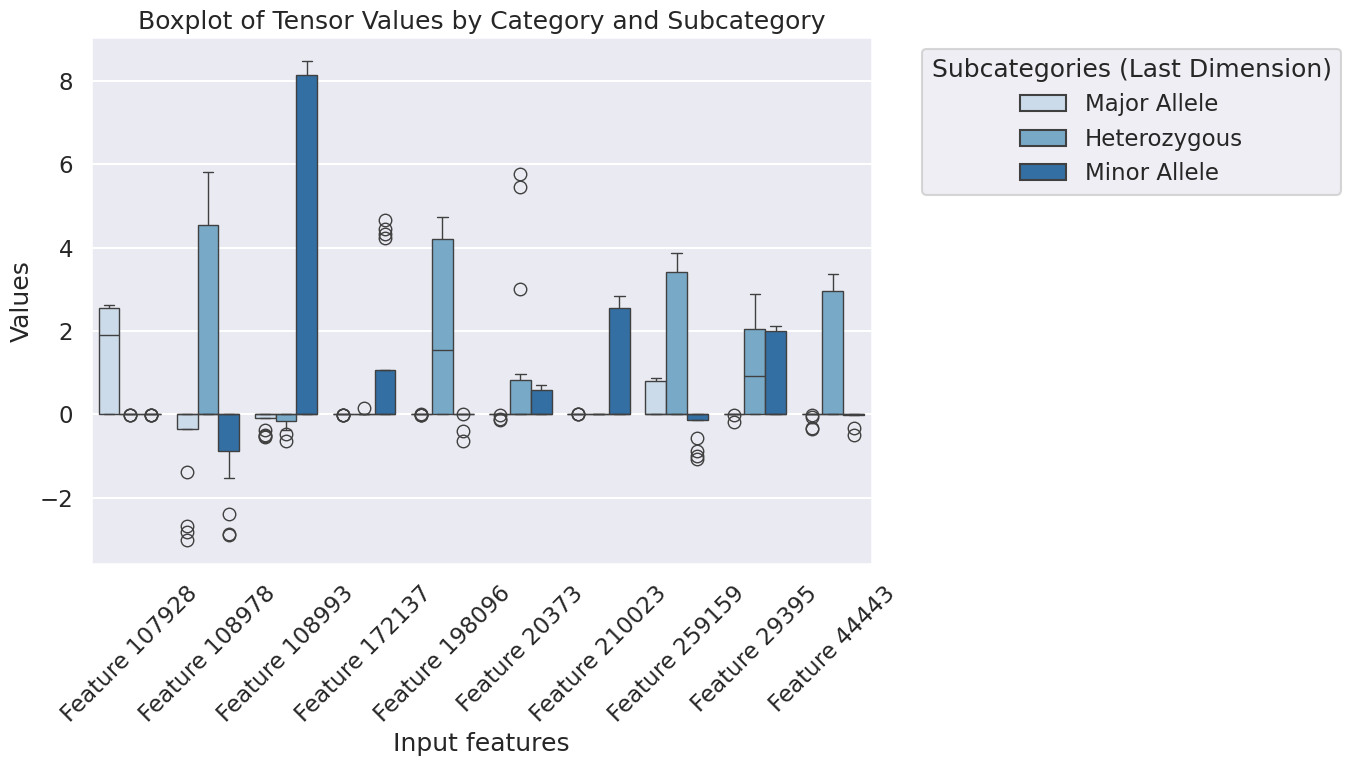

In [43]:
data = attributions[:,tk_ind.long()].cpu().numpy()  # Convert to NumPy array
reshaped_data = data.reshape(-1, 3)  # Reshape into (16*10, 3)

# Create a DataFrame for plotting
df = pd.DataFrame(reshaped_data, columns=['Major Allele', 'Heterozygous', 'Minor Allele'])
df['Category'] = pd.Categorical(
    [f"Feature {int(i)}" for i in tk_ind.long()] * 16  # Assign categories based on the second dimension
)
df['Sample'] = df.index // 10  # Assign a unique sample ID for each set of 10

# Step 3: Melt the DataFrame for Seaborn
df_melted = df.melt(id_vars=['Category', 'Sample'], var_name='Subcategory', value_name='Value')

# Step 4: Plot the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_melted, x='Category', y='Value', hue='Subcategory', palette='Blues')

plt.title('Boxplot of Tensor Values by Category and Subcategory')
plt.xlabel('Input features')
plt.ylabel('Values')
plt.legend(title='Subcategories (Last Dimension)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
topk.indices/3

tensor([108993.6719, 198096.3438, 108978.3359, 107928.0000,  44443.3359,
        259159.3438, 210023.6719,  29395.3340, 172137.6719,  20373.3340],
       device='cuda:0')

In [92]:
topk.indices/3

tensor([108993.6719, 259159.3438, 296911.6875,  20373.3340,  44443.3359,
        413855.6875, 172137.6719, 328155.3438, 384584.3438, 354455.6875],
       device='cuda:0')

In [44]:
topk = torch.topk(abs_mean.flatten(), 20)
tk_ind = torch.floor(topk.indices/3)

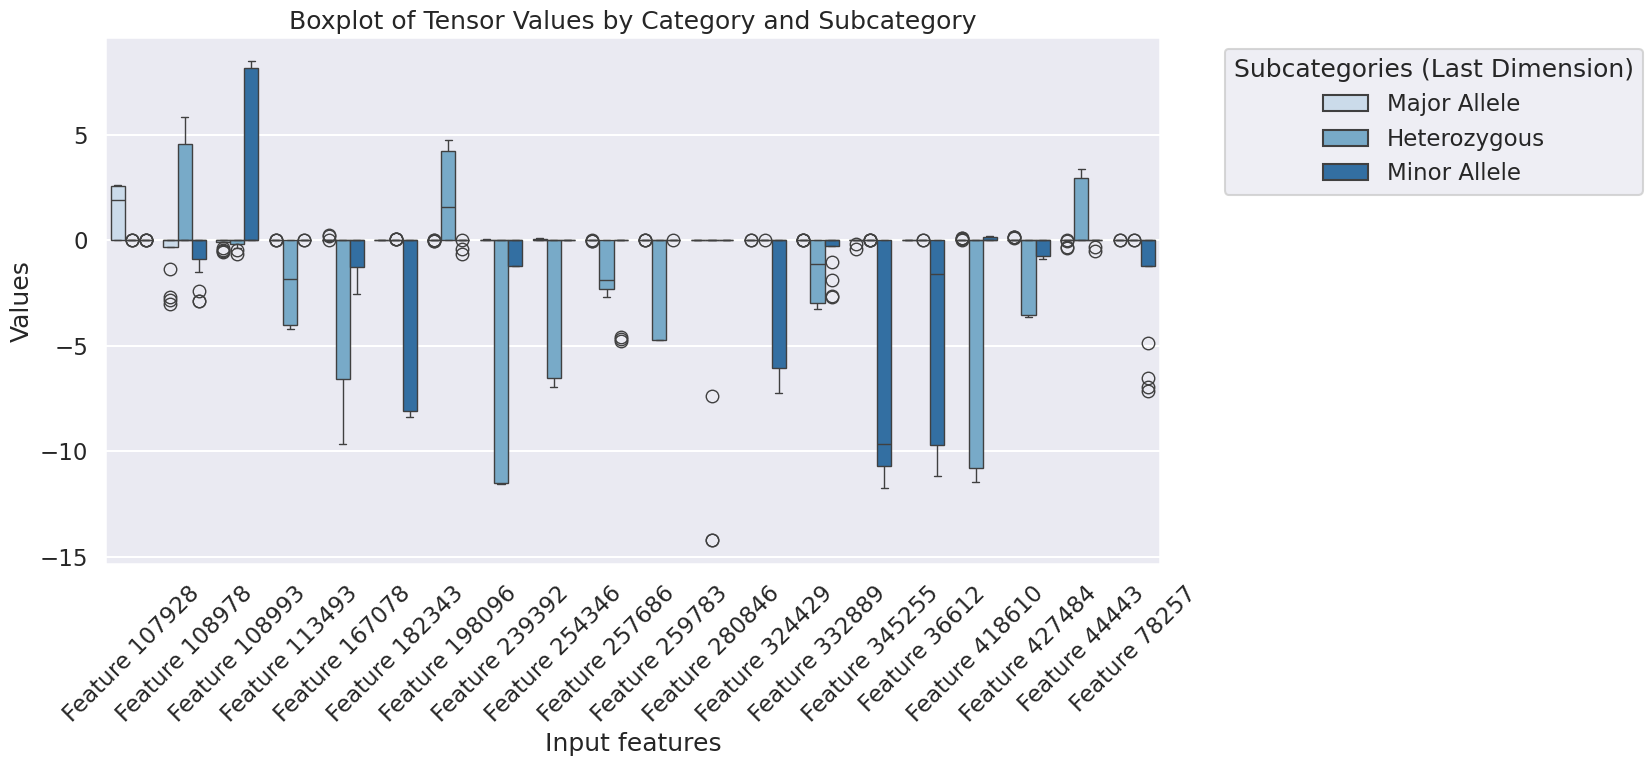

In [45]:
data = attributions[:,tk_ind.long()].cpu().numpy()  # Convert to NumPy array
reshaped_data = data.reshape(-1, 3)  # Reshape into (16*10, 3)

# Create a DataFrame for plotting
df = pd.DataFrame(reshaped_data, columns=['Major Allele', 'Heterozygous', 'Minor Allele'])
df['Category'] = pd.Categorical(
    [f"Feature {int(i)}" for i in tk_ind.long()] * 16  # Assign categories based on the second dimension
)
df['Sample'] = df.index // 10  # Assign a unique sample ID for each set of 10

# Step 3: Melt the DataFrame for Seaborn
df_melted = df.melt(id_vars=['Category', 'Sample'], var_name='Subcategory', value_name='Value')

# Step 4: Plot the boxplot
plt.figure(figsize=(17, 8))
sns.boxplot(data=df_melted, x='Category', y='Value', hue='Subcategory', palette='Blues')

plt.title('Boxplot of Tensor Values by Category and Subcategory')
plt.xlabel('Input features')
plt.ylabel('Values')
plt.legend(title='Subcategories (Last Dimension)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# map back to snp id map
snp_id_map

{'rs13303101': 0,
 'rs192998324': 1,
 'rs55678698': 2,
 'rs2340588': 3,
 'rs146327803': 4,
 'rs41285790': 5,
 'rs9988179': 6,
 'rs74047407': 7,
 'rs2001730': 8,
 'rs77579483': 9,
 'Affx-89007868': 10,
 'rs1110052': 11,
 'rs199625867': 12,
 'Affx-89008640': 13,
 'rs200584816': 14,
 'Affx-52325915': 15,
 'Affx-80267079': 16,
 'rs200048444': 17,
 'rs3748592': 18,
 'rs3748593': 19,
 'rs144656266': 20,
 'rs74047418': 21,
 'rs144879626': 22,
 'Affx-80210141': 23,
 'rs2272757': 24,
 'rs35471880': 25,
 'rs139055451': 26,
 'rs67274836': 27,
 'rs114631528': 28,
 'Affx-80290518': 29,
 'Affx-15447216': 30,
 'rs3748597': 31,
 'rs13302945': 32,
 'Affx-80210145': 33,
 'rs3828049': 34,
 'Affx-89023000': 35,
 'rs13303065': 36,
 'rs112164716': 37,
 'Affx-80267082': 38,
 'Affx-80210147': 39,
 'rs144217019': 40,
 'Affx-80210148': 41,
 'rs115438739': 42,
 'rs13303010': 43,
 'Affx-52350436': 44,
 'rs138690517': 45,
 'Affx-80290520': 46,
 'rs6696971': 47,
 'rs147703918': 48,
 'rs199823418': 49,
 'Affx-920425

In [51]:
snp_df = pd.DataFrame.from_dict(snp_id_map, orient="index",columns=["snp_feature_id"])
snp_df

,snp_feature_id
rs13303101,0
rs192998324,1
rs55678698,2
rs2340588,3
rs146327803,4
...,...
Affx-34461837,429366
Affx-79381713,429367
Affx-89025698,429368
Affx-79381714,429369


In [53]:
snp_df.reset_index().set_index("snp_feature_id").loc[tk_ind.long().cpu()]

,index
snp_feature_id,
345255,rs118012167
36612,rs41304163
418610,Affx-80265754
239392,Affx-80295545
182343,rs61749954
108993,rs2231142
167078,rs200913289
324429,rs77262761
280846,rs114223788


In [10]:
snp_df.reset_index().set_index("snp_feature_id").loc[113493]

NameError: name 'snp_df' is not defined